In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
import numpy as np
M=20

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Spark Session

In [28]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('clustering').getOrCreate()
print('Spark Version: {}'.format(spark.version))
sc=spark.sparkContext

Spark Version: 3.4.0


## Read Data

In [29]:
rdd= sc.textFile('/content/drive/MyDrive/BD_Dataset')
header= rdd.first()
rdd= rdd.filter(lambda x: x!=header)
rdd.take(1)

['Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10,15,True,0.0,USD,10M,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,https://beniyizibyose.tk/#/,jean21101999@gmail.com,Feb 26  2020,Feb 26  2020,Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35']

# K-mean Clustering

## choose features

In [72]:
ratings= rdd.map(lambda x: x.split(',')[3] )
ratings.take(10)
ratings= ratings.filter(lambda x: x != '')
ratings= ratings.map(lambda x: float(x))


## choose value of k

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans


In [73]:
ratings_df=ratings.map(lambda x: (x, )).toDF()

In [75]:
print(type(ratings_df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [31]:
k=4
centroids= ratings.takeSample(False, k, 0)
print(centroids)
# centroids=[2, 3, 5, 4.5 , 0]

['4.6', '5.0', '0.0', '3.6']


In [46]:
# compute ecludian distance between x and each cetroid in centroids and return centroid with min distance
def compute_closest_centroid(x, centroids):
    distances = [ np.sqrt(np.sum((float(x) - centroid)**2)) for centroid in centroids]
    return np.argmin(distances)

## Apply Map-Reduce


In [33]:
'''
map => compute distance between each point and the centroids 
produce  key- value pair <index of mean with min- distance, value of the features>
reduce => compute the new means for each cluster

'''

'\nmap => compute distance between each point and the centroids \nproduce  key- value pair <index of mean with min- distance, value of the features>\nreduce => compute the new means for each cluster\n\n'

In [48]:
new_centroids =[]
i=0
while i < M:
  i+=1
  map_result= ratings.map( lambda x:(compute_closest_centroid(x, centroids), x) )
  map_values=map_result .mapValues(lambda x: (float(x),1))
  reduce_result=map_values.reduceByKey(lambda x,y: (float(x[0])+float(y[0]), x[1]+y[1]))\
        .mapValues(lambda x: x[0]/x[1])
  new_centroids= [item[1] for item in np.array(reduce_result.collect())]
  print("New: ",new_centroids)
  print("Old: ", centroids)
  if centroids != new_centroids :
    centroids = new_centroids
  else:
    break


New:  [2.0870699800832933, 3.3162234710232013, 4.918960900100035, 4.272557852642983, 0.0]
Old:  [2, 3, 5, 4.5, 0]
New:  [2.2670787279425975, 3.367232704925479, 4.807496924294363, 4.182654259146311, 0.0006723402248992197]
Old:  [2.0870699800832933, 3.3162234710232013, 4.918960900100035, 4.272557852642983, 0.0]
New:  [2.3590582407319842, 3.3976361015827554, 4.75170384028946, 4.134344139551907, 0.0009169321332577865]
Old:  [2.2670787279425975, 3.367232704925479, 4.807496924294363, 4.182654259146311, 0.0006723402248992197]
New:  [2.3590582407319842, 3.3976361015827554, 4.75170384028946, 4.134344139551907, 0.0009169321332577865]
Old:  [2.3590582407319842, 3.3976361015827554, 4.75170384028946, 4.134344139551907, 0.0009169321332577865]


In [81]:
clusters= map_values.groupByKey().mapValues(list)

In [85]:
collected_clusters=clusters.collect()

In [96]:
clusters_it=  [item[1] for item in collected_clusters]
print(clusters_it[0])


[(2.0, 1), (2.5, 1), (2.3, 1), (2.1, 1), (2.7, 1), (2.7, 1), (2.4, 1), (2.6, 1), (2.6, 1), (1.5, 1), (2.4, 1), (2.5, 1), (2.4, 1), (1.3, 1), (2.1, 1), (2.8, 1), (2.1, 1), (2.6, 1), (2.2, 1), (2.0, 1), (2.8, 1), (2.6, 1), (2.8, 1), (2.1, 1), (2.2, 1), (2.0, 1), (1.8, 1), (1.4, 1), (1.2, 1), (2.6, 1), (2.6, 1), (2.5, 1), (2.7, 1), (2.4, 1), (2.2, 1), (2.7, 1), (2.2, 1), (2.8, 1), (2.7, 1), (2.8, 1), (2.5, 1), (2.4, 1), (2.0, 1), (2.8, 1), (2.4, 1), (2.3, 1), (1.9, 1), (2.4, 1), (2.1, 1), (2.7, 1), (2.5, 1), (2.8, 1), (2.8, 1), (1.7, 1), (2.1, 1), (2.6, 1), (2.2, 1), (2.8, 1), (2.2, 1), (2.1, 1), (1.8, 1), (2.4, 1), (1.9, 1), (2.5, 1), (2.3, 1), (2.7, 1), (2.8, 1), (2.7, 1), (2.4, 1), (2.2, 1), (2.1, 1), (2.6, 1), (1.9, 1), (2.8, 1), (2.8, 1), (2.5, 1), (2.7, 1), (2.8, 1), (1.4, 1), (2.8, 1), (2.3, 1), (2.8, 1), (2.7, 1), (1.6, 1), (2.6, 1), (2.7, 1), (2.6, 1), (2.7, 1), (2.5, 1), (2.6, 1), (1.7, 1), (2.3, 1), (2.4, 1), (2.4, 1), (2.5, 1), (2.1, 1), (2.7, 1), (2.5, 1), (1.4, 1), (2.7, 1),

In [100]:
actual_clusters=[]
for i in clusters_it:
   actual_clusters.append([x[0] for x in i])

In [101]:
print(actual_clusters[0])

[2.0, 2.5, 2.3, 2.1, 2.7, 2.7, 2.4, 2.6, 2.6, 1.5, 2.4, 2.5, 2.4, 1.3, 2.1, 2.8, 2.1, 2.6, 2.2, 2.0, 2.8, 2.6, 2.8, 2.1, 2.2, 2.0, 1.8, 1.4, 1.2, 2.6, 2.6, 2.5, 2.7, 2.4, 2.2, 2.7, 2.2, 2.8, 2.7, 2.8, 2.5, 2.4, 2.0, 2.8, 2.4, 2.3, 1.9, 2.4, 2.1, 2.7, 2.5, 2.8, 2.8, 1.7, 2.1, 2.6, 2.2, 2.8, 2.2, 2.1, 1.8, 2.4, 1.9, 2.5, 2.3, 2.7, 2.8, 2.7, 2.4, 2.2, 2.1, 2.6, 1.9, 2.8, 2.8, 2.5, 2.7, 2.8, 1.4, 2.8, 2.3, 2.8, 2.7, 1.6, 2.6, 2.7, 2.6, 2.7, 2.5, 2.6, 1.7, 2.3, 2.4, 2.4, 2.5, 2.1, 2.7, 2.5, 1.4, 2.7, 2.4, 2.6, 2.1, 2.8, 2.6, 2.7, 2.1, 2.7, 2.6, 2.8, 2.7, 2.4, 2.4, 2.7, 2.8, 2.0, 1.8, 2.6, 2.8, 2.5, 2.6, 2.7, 2.2, 2.2, 2.7, 2.7, 1.5, 2.6, 2.4, 2.7, 2.8, 1.7, 2.5, 2.8, 1.4, 2.7, 2.0, 2.0, 2.8, 2.3, 2.4, 2.8, 2.4, 2.7, 1.8, 2.6, 2.3, 1.8, 2.2, 2.2, 2.3, 2.8, 2.3, 2.4, 2.8, 2.1, 2.1, 2.6, 2.4, 2.8, 2.8, 1.8, 2.3, 2.6, 2.1, 2.6, 2.2, 2.6, 2.5, 2.7, 2.5, 2.5, 1.9, 2.5, 2.2, 1.9, 2.2, 2.3, 2.5, 2.7, 2.5, 2.8, 2.4, 2.7, 2.6, 2.3, 2.6, 2.4, 2.8, 2.8, 2.8, 2.5, 1.4, 2.0, 2.7, 2.8, 2.1, 2.3, 2.8, 2.2,

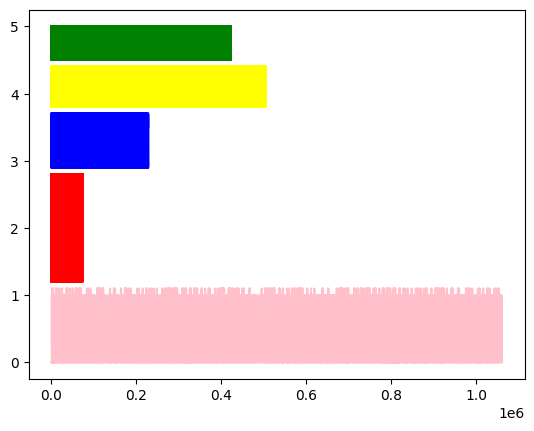

In [110]:
# plt.scatter(actual_clusters[0], actual_clusters[0], color='red')
plt.plot(actual_clusters[1], color='blue')
plt.plot(actual_clusters[0], color='red')
plt.plot(actual_clusters[2], color='green')
plt.plot(actual_clusters[3], color='yellow')
plt.plot(actual_clusters[4], color='pink')

plt.show()

In [23]:

#End Session
spark.stop()